## Langgraph

# Lecture 8- Langgraph Day 1

### Langraph is a library that helps you bulid agents in the forms of nodes and edges.

References:https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb#scrollTo=63edff5a-724b-474d-9db8-37f0ae936c76

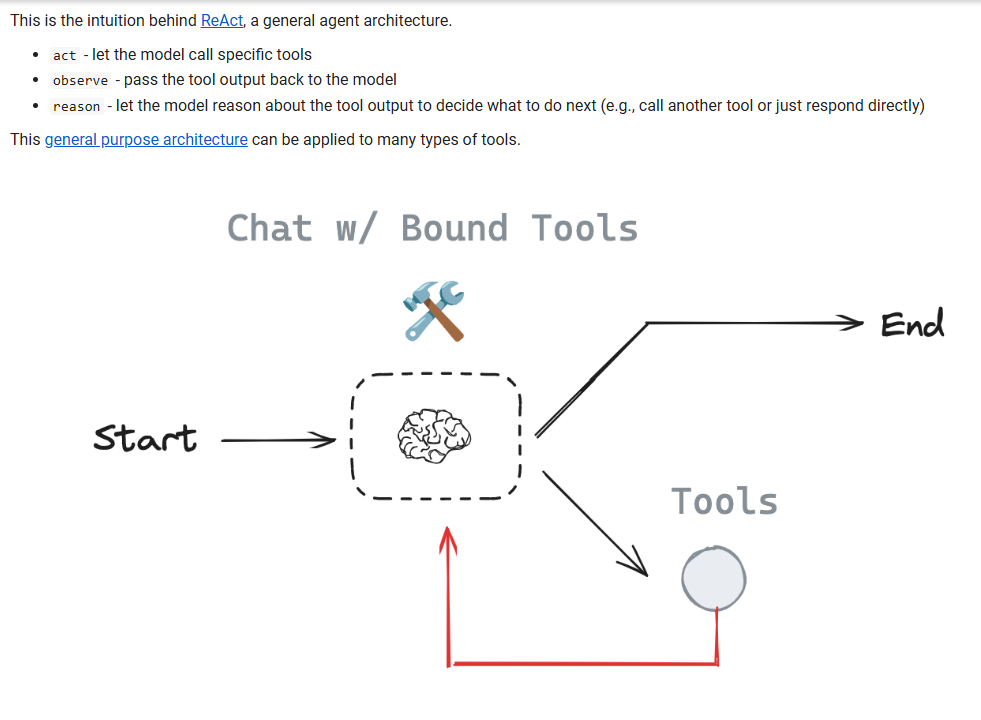

In [1]:
# Images from database

# Display image in Jupyter notebook
from IPython.display import display, Image

path = "lecture1.png"
display(Image(filename=path))  # display image

In [2]:
%pip install --quiet -U langchain_openai langchain_core langgraph

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env file

# Corrected way to retrieve the API key
api_key = os.getenv("GOOGLE_API_KEY")

if not api_key:
    raise ValueError("GOOGLE_API_KEY not found. Make sure it's set in the .env file.")

os.environ["GOOGLE_API_KEY"] = api_key

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

from datetime import datetime

In [28]:
# Step 2: Define a tool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

widipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000000))

# print(widipedia_tool.run({"query": "What is the capital of France?"}))

def wikipedia_too_fun(query: str) -> str:
    """Search wikipedia for the query.
    Args:
        query (str): The query to search for.
    Returns:
        str: The answer to the query.
    """

    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000000))
    return widipedia_tool.run({"query": query})

In [29]:
# Step 3: Bind an LLM with tools
tools = [wikipedia_too_fun]
llm_with_tools = llm.bind_tools(tools)

In [30]:
# Step 4: Define a System Message
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# State is the input schema for the for all the nodes and edges in graph

# System message
sys_msg = SystemMessage(content="You are a helpful assistant helps answer questions about the world using the wikipedia tool,given the user query break it down into a wikipedia keyword and use the wikipedia tool to get the answer")

# Node, overrides the graph state, here we are appending the system message with user query
def assistant(state: MessagesState):
    return { "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])] }

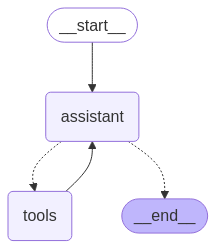

In [31]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import display, Image

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work, these are the python functions
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these are the conditions that determine which node to run next
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", 
    # If the latest message (result) from assistant is a tool call -> then run the tool node
    # If the latest message (result) from assistant is not a tool call -> then route the tool_condition to the END node
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [32]:
messages = [HumanMessage(content="Essay on India")]
messages = react_graph.invoke({"messages": messages})

In [33]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Essay on India
================================== Ai Message ==================================
Tool Calls:
  wikipedia_too_fun (31cd59e2-74d1-46c4-aa20-c8875c4c7353)
 Call ID: 31cd59e2-74d1-46c4-aa20-c8875c4c7353
  Args:
    query: India
================================= Tool Message =================================
Name: wikipedia_too_fun

Page: India
Summary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country from June 2023 onwards; and since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is near Sri Lanka and the Maldives; its Anda